/tmp/ipykernel_13213/1552748457.py:13: RuntimeWarning: invalid value encountered in divide
  norm_img[:, :, c] = np.divide(img[:, :, c], rimg[:, :, c])
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x79cee6641da0>
Traceback (most recent call last):
  File "/home/alejandro/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/alejandro/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/alejandro/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/alejandro/anaconda3/lib/python3.11/site-

[[ 73  18 238]
 [  0   0   0]
 [ 60  28 221]
 [ 82  14 251]]


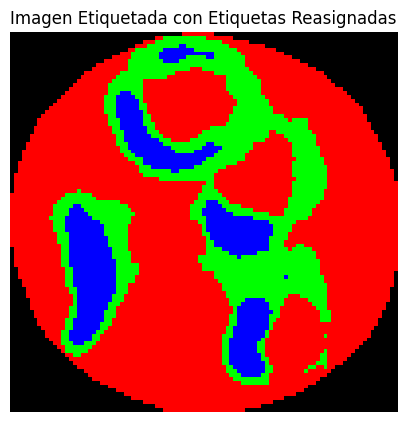

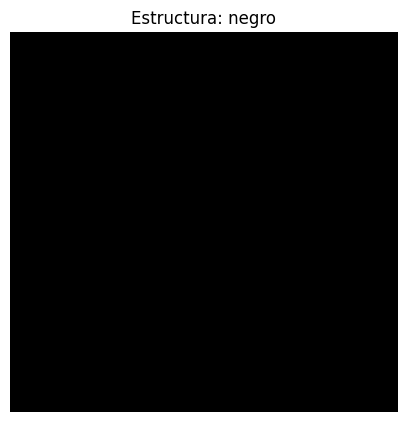

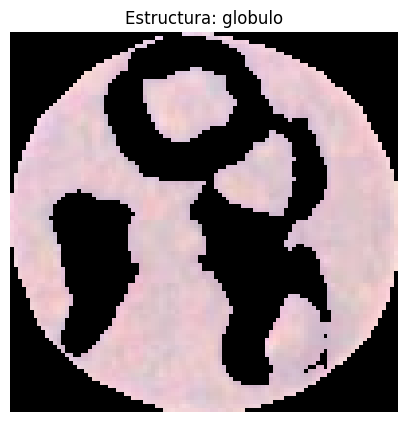

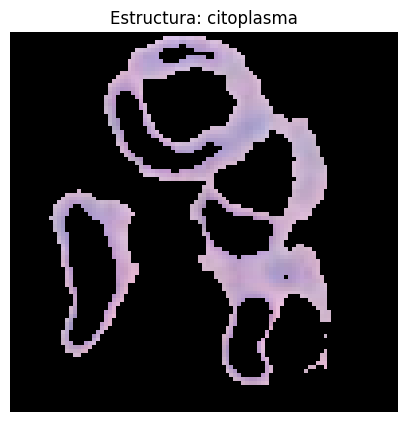

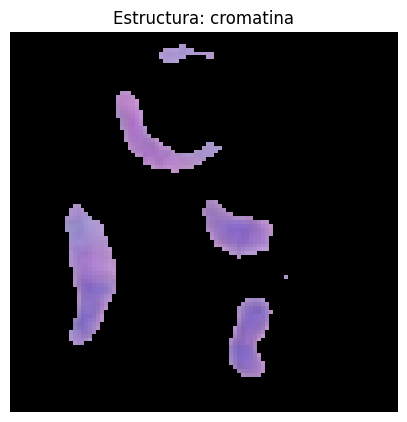

Conteo de píxeles por grupo con etiquetas reasignadas:
globulo: 4989 píxeles
negro: 2000 píxeles
citoplasma: 1763 píxeles
cromatina: 851 píxeles


In [61]:
from collections import defaultdict
from sklearn.metrics import pairwise_distances_argmin_min
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import color as skcolor
import pandas as pd

# Definir la función de normalización de imagen
def normalize_img(img: np.ndarray, rimg: np.ndarray) -> np.ndarray:
    norm_img = np.zeros_like(img, dtype=np.float64)
    for c in range(3):
        norm_img[:, :, c] = np.divide(img[:, :, c], rimg[:, :, c])
        norm_img[:, :, c] = np.nan_to_num(norm_img[:, :, c], nan=0)
    norm_img = np.clip(norm_img, 0, 1)
    return norm_img

def CilToCart(arr):
    
    z = arr[:,0]
    rho = arr[:,1]
    phi = arr[:,2]
    x = rho * np.cos( phi )
    y = rho * np.sin( phi )
    arr[:,1] = x
    arr[:,2] = y
    return arr   

# Ajustar las rutas de las imágenes
img_path = 'img/2023-08-08 19.38.42-1_seg_000.png'
rimg_path = 'img/2023-08-08 19.38.42-1_seg_000_ref.png'

# Leer las imágenes
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
rimg = cv2.cvtColor(cv2.imread(rimg_path), cv2.COLOR_BGR2RGB)

# Normalizar la imagen
norm_img = normalize_img(img, rimg)

# Convertir la imagen normalizada a espacio de color LAB y LCH
lab_image = skcolor.rgb2lab(norm_img)
lch_image = skcolor.lab2lch(lab_image)

# Convertir LCH a coordenadas cartesianas
lch_image_cartesian = CilToCart(lch_image.copy().reshape(-1, 3)).reshape(lch_image.shape)

# Crear la imagen LABCH (L, a, b, C, H)
labch_image = np.stack((lab_image[:, :, 0], lab_image[:, :, 1], lab_image[:, :, 2], lch_image[:, :, 1], lch_image[:, :, 2]), axis=-1)

# Redimensionar la imagen para el clustering
original_shape = lab_image.shape
lab_image_reshaped = lab_image.reshape((-1, 3))
lch_image_reshaped = lch_image.reshape((-1, 3))

lab_image_reshaped = np.float32(lab_image_reshaped)
lch_image_reshaped = np.float32(lch_image_reshaped)

# Aplicar clustering k-means
stop_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1.0)
number_of_attempts = 30
centroid_initialization_strategy = cv2.KMEANS_RANDOM_CENTERS
K = 4
_, labels, centers = cv2.kmeans(lab_image_reshaped, K, None, stop_criteria, number_of_attempts, centroid_initialization_strategy)

centers = np.uint8(centers)

# Reconstruir la imagen segmentada
segmented_data = centers[labels.flatten()]
segmented_image = segmented_data.reshape(original_shape)

# Asignar etiquetas a los centros
label_names = ["negro", "globulo", "citoplasma", "cromatina"]

# Calcular la distancia de cada píxel a los centros
closest_centers, distances = pairwise_distances_argmin_min(segmented_image.reshape(-1, 3), centers)

# Reestructurar la matriz closest_centers para que coincida con la imagen original
closest_centers = closest_centers.reshape(segmented_image.shape[:2])

# Crear una imagen para almacenar las etiquetas
label_image = np.empty(segmented_image.shape[:2], dtype=object)

# Asignar etiquetas basado en la proximidad al centroide correspondiente
for i, label in enumerate(label_names):
    mask = closest_centers == i
    label_image[mask] = label

print(centers)

# Contar la cantidad de píxeles en cada grupo
pixel_counts = {label: np.sum(label_image == label) for label in label_names}

# Ordenar los grupos por cantidad de píxeles de mayor a menor
sorted_labels = sorted(pixel_counts, key=pixel_counts.get, reverse=True)

# Reasignar etiquetas según el nuevo orden
new_label_names = {
    sorted_labels[0]: "globulo",
    sorted_labels[1]: "negro",
    sorted_labels[2]: "citoplasma",
    sorted_labels[3]: "cromatina"
}

# Actualizar los colores según la nueva asignación
new_label_colors = {
    "negro": [0, 0, 0],
    "globulo": [255, 0, 0],
    "citoplasma": [0, 255, 0],
    "cromatina": [0, 0, 255],
}

# Crear una nueva imagen con las etiquetas reasignadas
reassigned_label_image = np.empty_like(label_image, dtype=object)

for old_label, new_label in new_label_names.items():
    reassigned_label_image[label_image == old_label] = new_label

# Crear la imagen con los nuevos colores
reassigned_colored_image = np.zeros((*reassigned_label_image.shape, 3), dtype=np.uint8)

for label, color in new_label_colors.items():
    reassigned_colored_image[reassigned_label_image == label] = color

# Mostrar la imagen corregida con los nuevos colores y etiquetas
plt.figure(figsize=(5, 5))
plt.imshow(reassigned_colored_image)
plt.title("Imagen Etiquetada con Etiquetas Reasignadas")
plt.axis('off')
plt.show()

# Graficar cada grupo por separado con las nuevas etiquetas y colores
for label in ["negro", "globulo", "citoplasma", "cromatina"]:
    mask = reassigned_label_image == label
    group_image = np.zeros_like(img)
    group_image[mask] = img[mask]
    
    plt.figure(figsize=(5, 5))
    plt.imshow(group_image)
    plt.title(f"Estructura: {label}")
    plt.axis('off')
    plt.show()

# Crear un DataFrame para almacenar los valores RGB originales y sus etiquetas reasignadas
data = []
for i in range(reassigned_label_image.shape[0]):
    for j in range(reassigned_label_image.shape[1]):
        if reassigned_label_image[i, j] != "negro":  # Excluir píxeles con la etiqueta "negro"
            rgb_value = list(img[i, j])
            labch_value = list(labch_image[i, j])
            label = reassigned_label_image[i, j]
            data.append([rgb_value,labch_value,label])

df = pd.DataFrame(data, columns=["RGB","LABCH","Etiqueta"])

# Mostrar una vista previa del DataFrame
df.head()

# Contar y mostrar los pixeles por grupo con las nuevas etiquetas
new_pixel_counts = {new_label_names[old_label]: pixel_counts[old_label] for old_label in label_names}
new_pixel_counts = dict(sorted(new_pixel_counts.items(), key=lambda item: item[1], reverse=True))
print("Conteo de píxeles por grupo con etiquetas reasignadas:")
for label, count in new_pixel_counts.items():
    print(f"{label}: {count} píxeles")


In [62]:
df

,RGB,LABCH,Etiqueta
0,"[231, 211, 236]","[87.27877510315894, 13.916538279435397, -14.65...",globulo
1,"[237, 215, 238]","[88.805496966016, 14.173380476512953, -13.4215...",globulo
2,"[235, 211, 233]","[87.51936834870294, 14.643729744773848, -12.60...",globulo
3,"[229, 204, 225]","[85.0729860773213, 14.795038169039765, -11.884...",globulo
4,"[234, 205, 225]","[85.74435419616259, 15.94184895693973, -10.837...",globulo
...,...,...,...
7598,"[230, 200, 202]","[83.51799670214133, 13.007620201770875, -1.367...",globulo
7599,"[231, 201, 203]","[83.87727802692291, 13.005968530140466, -1.389...",globulo
7600,"[238, 208, 208]","[86.32903021585672, 12.647479236122694, -0.508...",globulo
7601,"[240, 210, 208]","[86.98862996476245, 12.300269125486984, 0.4757...",globulo


In [63]:
# Convertir las listas RGB en columnas separadas para calcular los rangos
df_rgb_expanded = pd.DataFrame(df['RGB'].tolist(), columns=['R', 'G', 'B'])
df_expanded = pd.concat([df_rgb_expanded, df['Etiqueta']], axis=1)

# Calcular los rangos de valores RGB por estructura
rgb_ranges = df_expanded.groupby("Etiqueta").agg({
    'R': ['min', 'max'],
    'G': ['min', 'max'],
    'B': ['min', 'max']
})

# Mostrar los rangos de valores RGB por estructura
for label, ranges in rgb_ranges.iterrows():
    print(f"Rangos de valores RGB para la estructura '{label}':")
    print(f"Rojo (R): {ranges['R']['min']} - {ranges['R']['max']}")
    print(f"Verde (G): {ranges['G']['min']} - {ranges['G']['max']}")
    print(f"Azul (B): {ranges['B']['min']} - {ranges['B']['max']}")
    print("-" * 40)


Rangos de valores RGB para la estructura 'citoplasma':
Rojo (R): 160 - 234
Verde (G): 138 - 200
Azul (B): 182 - 235
----------------------------------------
Rangos de valores RGB para la estructura 'cromatina':
Rojo (R): 125 - 202
Verde (G): 101 - 159
Azul (B): 179 - 217
----------------------------------------
Rangos de valores RGB para la estructura 'globulo':
Rojo (R): 187 - 255
Verde (G): 175 - 223
Azul (B): 187 - 239
----------------------------------------


In [64]:
# Convertir las listas LABCH en columnas separadas para calcular los rangos
df_labch_expanded = pd.DataFrame(df['LABCH'].tolist(), columns=['L', 'a', 'b', 'C', 'H'])
df_expanded_labch = pd.concat([df_labch_expanded, df['Etiqueta']], axis=1)

# Calcular los rangos de valores LABCH por estructura
labch_ranges = df_expanded_labch.groupby("Etiqueta").agg({
    'L': ['min', 'max'],
    'a': ['min', 'max'],
    'b': ['min', 'max'],
    'C': ['min', 'max'],
    'H': ['min', 'max']
})

# Mostrar los rangos de valores LABCH por estructura
for label, ranges in labch_ranges.iterrows():
    print(f"Rangos de valores LABCH para la estructura '{label}':")
    print(f"Luminosidad (L): {ranges['L']['min']} - {ranges['L']['max']}")
    print(f"a*: {ranges['a']['min']} - {ranges['a']['max']}")
    print(f"b*: {ranges['b']['min']} - {ranges['b']['max']}")
    print(f"Croma (C): {ranges['C']['min']} - {ranges['C']['max']}")
    print(f"Tono (H): {ranges['H']['min']} - {ranges['H']['max']}")
    print("-" * 40)


Rangos de valores LABCH para la estructura 'citoplasma':
Luminosidad (L): 61.88119034152234 - 83.98777148874963
a*: 9.4633035802823 - 27.659466660784616
b*: -29.75904707942012 - -9.530116658683752
Croma (C): 15.468692947814793 - 37.55040050213915
Tono (H): 5.211226655884856 - 5.861454112871206
----------------------------------------
Rangos de valores LABCH para la estructura 'cromatina':
Luminosidad (L): 49.63776530798616 - 69.77627708555272
a*: 16.235502937617554 - 39.09475238475496
b*: -51.20976207077257 - -22.942248240374475
Croma (C): 31.697130351941464 - 62.15594620058147
Tono (H): 5.211243565348406 - 5.568874053949039
----------------------------------------
Rangos de valores LABCH para la estructura 'globulo':
Luminosidad (L): 73.13614126496368 - 91.20920784884132
a*: 5.336262059771224 - 23.386110232752223
b*: -15.861010915845352 - 3.8490622002735897
Croma (C): 6.90673645926628 - 26.70006289286506
Tono (H): 0.0008218063018399492 - 6.2810499249559575
----------------------------